## Setup

Load libraries

In [1]:
import sys

sys.path.append('..')

In [2]:
import os
import glob as gb
import numpy as np
import pandas as pd
import scipy.io as sio
from matplotlib import pyplot as plt
from utils.plotting_utils import plot_var

## Load Remote Sensing (InSAR and Lidar) Data

In [3]:
raster = sio.loadmat('../data/UAVSAR-ASO-WMesa.mat')

## Data Preprocessing

* Let's extract all useful variables and convert them to a dataframe.

In [4]:
feb8_snow_depth=raster['r'][0][0][0]
feb21_snow_depth=raster['r'][0][1][0]
feb25_snow_depth=raster['r'][0][2][0]
sept26_bare_DEM=raster['r'][0][3][0]
sept26_veg_ht=raster['r'][0][4][0]
amplitude=raster['r2'][0][0][0]
unwrapped_phase=raster['r2'][0][1][0]
coherence=raster['r2'][0][2][0]
incidence_angle=raster['r2'][0][3][0]
elevation=raster['r2'][0][4][0]
wrapped_phase=raster['r2'][0][5][0]
easting=raster['r'][0][0][1]
northing=raster['r'][0][0][2]


# Create a dataframe
df = pd.DataFrame(
    {
        'idx': np.arange(1, feb8_snow_depth.ravel().shape[0]+1),
        'northing': np.repeat(a=northing.ravel(), repeats=easting.shape[1]),
        'easting': np.tile(A=easting.ravel(), reps=northing.shape[1]),
        'amplitude': amplitude.ravel(),
        'unwrapped_phase': unwrapped_phase.ravel(),
        'coherence': coherence.ravel(),
        'incidence_angle': incidence_angle.ravel(),
        'bare_earth_dem': sept26_bare_DEM.ravel(),
        'vegetation_ht': sept26_veg_ht.ravel(),
        'wrapped_phase': wrapped_phase.ravel(),
        'snow_depth': feb8_snow_depth.ravel(),
        'elevation': elevation.ravel()
    }
)

df.head()

,idx,northing,easting,amplitude,unwrapped_phase,coherence,incidence_angle,bare_earth_dem,vegetation_ht,wrapped_phase,snow_depth,elevation
0,1,4.322002e+06,220002.135674,0.424673,-10.83723,0.639889,0.929004,-9999.0,-9999.0,1.805211,-9999.0,2456.656494
1,2,4.322002e+06,220005.135915,0.424673,-10.83723,0.639889,0.929004,-9999.0,-9999.0,1.805211,-9999.0,2456.656494
2,3,4.322002e+06,220008.136156,0.381620,-10.83723,0.594642,0.929004,-9999.0,-9999.0,1.824319,-9999.0,2457.156494
3,4,4.322002e+06,220011.136396,0.381620,-10.83723,0.594642,0.926934,-9999.0,-9999.0,1.746802,-9999.0,2457.656494
4,5,4.322002e+06,220014.136637,0.369751,-10.83723,0.526593,0.924989,-9999.0,-9999.0,1.824319,-9999.0,2458.656616


* Cleaning Snow Depth

   - Create a new dataframe `clean_data` from  `df`.
   - Replace `0` and `253` in `snow_depth` column with `NaN`.
   - Replace snow depths greater than 3 m with `NaN`.
   - Replace all occurrencies of `-9999.0` in the dataframe with `NaN`.

In [5]:
clean_data=(
    df
    .assign(snow_depth=lambda df: df.snow_depth.where(~df.snow_depth.isin([0, 253]), other=np.nan))
    .assign(snow_depth=lambda df: df.snow_depth.where(df.snow_depth <=3, other=np.nan))
    .replace(-9999.0, np.nan)
)
clean_data.head()

,idx,northing,easting,amplitude,unwrapped_phase,coherence,incidence_angle,bare_earth_dem,vegetation_ht,wrapped_phase,snow_depth,elevation
0,1,4.322002e+06,220002.135674,0.424673,-10.83723,0.639889,0.929004,NaN,NaN,1.805211,NaN,2456.656494
1,2,4.322002e+06,220005.135915,0.424673,-10.83723,0.639889,0.929004,NaN,NaN,1.805211,NaN,2456.656494
2,3,4.322002e+06,220008.136156,0.381620,-10.83723,0.594642,0.929004,NaN,NaN,1.824319,NaN,2457.156494
3,4,4.322002e+06,220011.136396,0.381620,-10.83723,0.594642,0.926934,NaN,NaN,1.746802,NaN,2457.656494
4,5,4.322002e+06,220014.136637,0.369751,-10.83723,0.526593,0.924989,NaN,NaN,1.824319,NaN,2458.656616


## Plotting the products

In [6]:
# create a folder to save the plots

if not os.path.exists('../plots'):
    os.makedirs('../plots')
else:
    print('Folder already exists')

Folder already exists


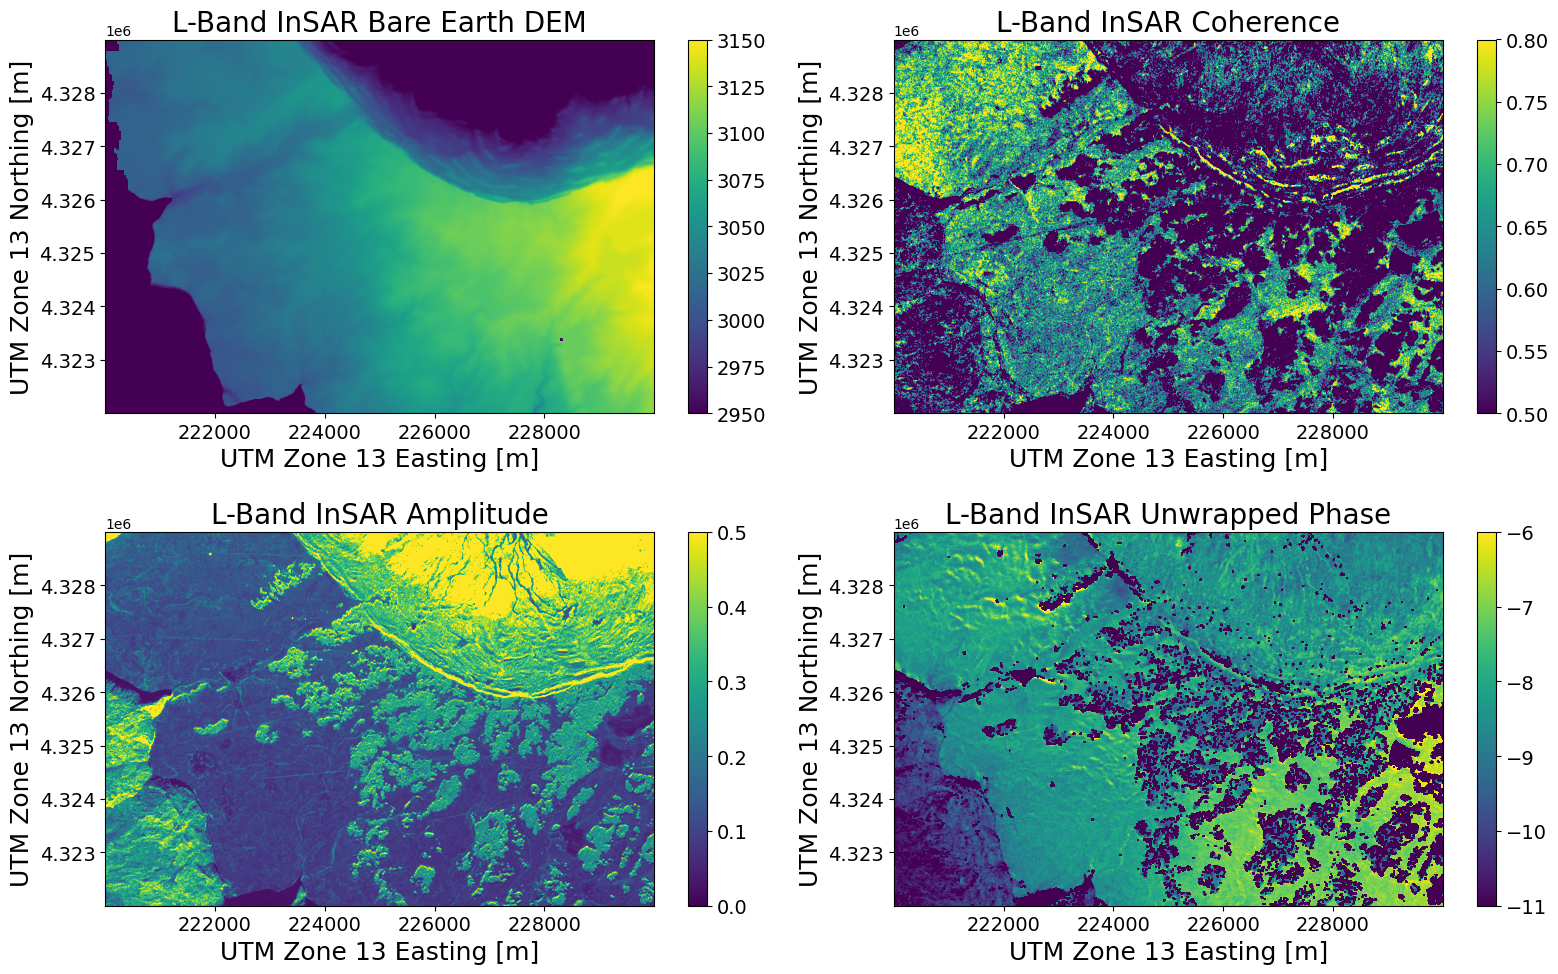

In [7]:
variables=[
    sept26_bare_DEM, coherence,
    amplitude, np.nan_to_num(unwrapped_phase, nan=-9999.0)
]

labels=[
    'L-Band InSAR Bare Earth DEM', 'L-Band InSAR Coherence',
    'L-Band InSAR Amplitude', 'L-Band InSAR Unwrapped Phase'
]

clims=[
    (2950, 3150), (0.5, 0.8),
    (0, 0.5), (-11, -6)
]

plt.figure(figsize=(16,10))
for j in range(1,5):
    ax=plt.subplot(2,2, j)
    plot_var(variable=variables[j-1], var_name=labels[j-1], clims=clims[j-1], easting=easting, northing=northing)
plt.tight_layout()

plt.savefig('../plots/insar_variables.png', dpi=300, bbox_inches='tight')

In [8]:
print(f"Data Shape: {feb8_snow_depth.shape}")

Data Shape: (2333, 3333)


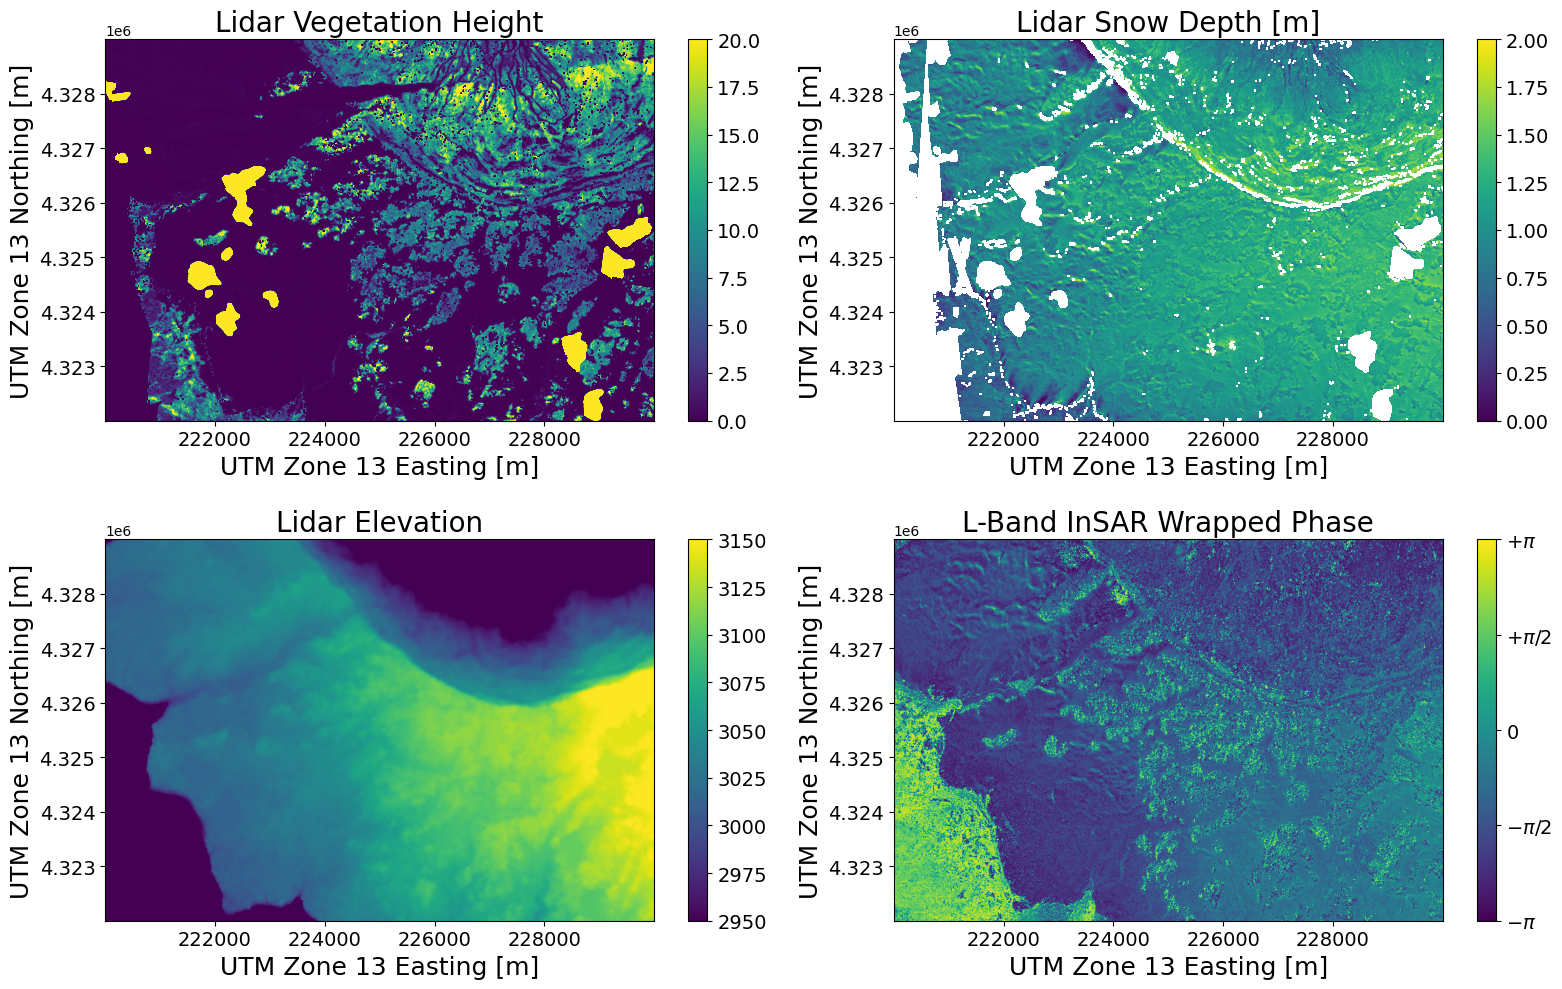

In [9]:
# reshape snow depth for plotting
shape=feb8_snow_depth.shape
clean_depth=clean_data.snow_depth.values.reshape(shape)

variables2=[
    sept26_veg_ht, clean_depth,
    elevation, wrapped_phase
]

labels2=[
    'Lidar Vegetation Height', 'Lidar Snow Depth [m]',
    'Lidar Elevation', 'L-Band InSAR Wrapped Phase'
]

clims2=[
    (0, 20), (0, 2),
    (2950, 3150), (-np.pi, np.pi)
]

plt.figure(figsize=(16, 10))
for j in range(1,5):
    ax=plt.subplot(2,2, j)
    if j==4:
      plot_var(variable=variables2[j-1], var_name=labels2[j-1], clims=clims2[j-1], pi_cbar=True, easting=easting, northing=northing)
    else:
      plot_var(variable=variables2[j-1], var_name=labels2[j-1], clims=clims2[j-1], easting=easting, northing=northing)
plt.tight_layout()

plt.savefig('../plots/lidar_variables.png', dpi=300)

## Check Missing Values

In [6]:
clean_data.isna().sum()

idx                     0
northing                0
easting                 0
amplitude               0
unwrapped_phase    352022
coherence               0
incidence_angle         0
bare_earth_dem     281827
vegetation_ht      317721
wrapped_phase           0
snow_depth         806241
elevation               0
dtype: int64

### Write Data to Parquet

In [7]:
# create a folder to store data

if not os.path.exists('../data'):
    os.makedirs('../data')
else:
    print('Folder already exists')

Folder already exists


* Dataframe with null values only

In [16]:
nulls=clean_data.loc[:, ['idx', 'northing', 'easting', 'snow_depth']][clean_data.isna().any(axis=1)]

In [17]:
(
    nulls
    .to_csv('../data/nulls_only.csv', index=False)
)

* Dataframes with non-null values

In [10]:
clean_data.dropna().to_parquet('../data/clean_data.parquet.gzip', index=False, compression='gzip')

## Load In-situ Snow Depths

The ground truth data was downloaded from [NSIDC](https://nsidc.org/data/snex17_sd/versions/1). The page contains the steps for downloading the data.

In [11]:
path="../data/SNOWEX/SNEX17_SD.001/2017.02.06"

all_files=gb.glob(path+"/*.csv")

* Select files for analysis

We want to select files that doesn't contain "points" and "comments" in the file names.

In [12]:
files_for_analysis = [file for file in all_files if "points" not in file and "comments" not in file]

* Load data (02/06/2017 - 02/25/2017) into a dataframe

In [13]:
# Skip the first 4 rows and dropping the "Distance [m]" column from each.
mapper = map(lambda x: pd.read_csv(x, skiprows=4).drop("Distance [m]", axis=1), files_for_analysis)
df_list = list(mapper)
insitu=pd.concat(df_list, axis=0, ignore_index=True)
all_insitu=insitu.assign(observed_snow_depth=lambda x: x['Snow Depth [cm]']/100).drop("Snow Depth [cm]", axis=1)
all_insitu=all_insitu.rename(columns={
    '#Easting [m]': 'easting',
    'Northing [m]': 'northing',
})

valid_idx=all_insitu.observed_snow_depth.between(left=0, right=3, inclusive="right")

all_insitu = (
    all_insitu
    .loc[valid_idx, :]
    .reset_index(drop=True)
) 

all_insitu.head()

,easting,northing,observed_snow_depth
0,261318.0,4198886.0,1.44
1,261314.5,4198886.0,1.75
2,261311.0,4198886.0,2.04
3,261307.5,4198886.0,2.02
4,261304.0,4198886.0,1.57


* Let's import insitu snow depths for feb 8 only (because we trained with feb 08 Lidar).

In [14]:
# select feb 08 files.
feb_08_depths_files = [filename for filename in files_for_analysis if "20170208" in filename]

mapper = map(lambda x: pd.read_csv(x, skiprows=4).drop("Distance [m]", axis=1), feb_08_depths_files)
df_list = list(mapper)
insitu=pd.concat(df_list, axis=0, ignore_index=True)
insitu_feb_08=insitu.assign(observed_snow_depth=lambda x: x['Snow Depth [cm]']/100).drop("Snow Depth [cm]", axis=1)
insitu_feb_08=insitu_feb_08.rename(columns={
    '#Easting [m]': 'easting',
    'Northing [m]': 'northing',
})

valid_idx2=insitu_feb_08.observed_snow_depth.between(left=0, right=3, inclusive="right")

insitu_feb_08 = (
    insitu_feb_08
    .loc[valid_idx2, :]
    .reset_index(drop=True)
)

insitu_feb_08.head()

,easting,northing,observed_snow_depth
0,232262.0,4327196.0,1.10
1,232262.6,4327199.0,1.09
2,232263.3,4327202.1,1.09
3,232263.9,4327205.1,1.11
4,232264.5,4327208.1,1.18


## Write Processed In-situ Measurements to CSV

In [15]:
all_insitu.to_csv('../data/all_insitu.csv', index=False)
insitu_feb_08.to_csv('../data/insitu_feb_08.csv', index=False)